# Model Building

# Import Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import t
%matplotlib inline

# import csv file

In [23]:
avocado_df = pd.read_csv('..\\Dataset\\avocado_cleaned.csv')
avocado_df['Date'] = pd.to_datetime(avocado_df['Date'])
avocado_df.head()

,Date,AveragePrice,TotalVolume,plu4046,plu4225,plu4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,BaltimoreWashington


## Split dataset (To exclude regional level)

In [24]:
# Broad regional categories
broad_regions = ['TotalUS', 'West', 'SouthCentral', 'Southeast', 'Midsouth', 
                 'GreatLakes', 'Northeast', 'Plains', 'NorthernNewEngland']

city_level_data = avocado_df[~avocado_df['region'].isin(broad_regions)]

In [25]:
city_level_data.shape

(45027, 12)

## Explore Data (EDA)

In [12]:
def univariate_analysis(data):
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

    for column in numeric_columns:
        print(f'\nAnalysis for {column}:\n')
        print(data[column].describe())
        
        plt.figure(figsize=(12, 6))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(data[column], kde=True, bins=30)
        plt.title(f'Histogram of {column}')
        
        # Box Plot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=data[column])
        plt.title(f'Box Plot of {column}')
        
        plt.tight_layout()
        plt.show()


Analysis for AveragePrice:

count    45027.000000
mean         1.435606
std          0.401477
min          0.440000
25%          1.120000
50%          1.401090
75%          1.700000
max          3.440830
Name: AveragePrice, dtype: float64


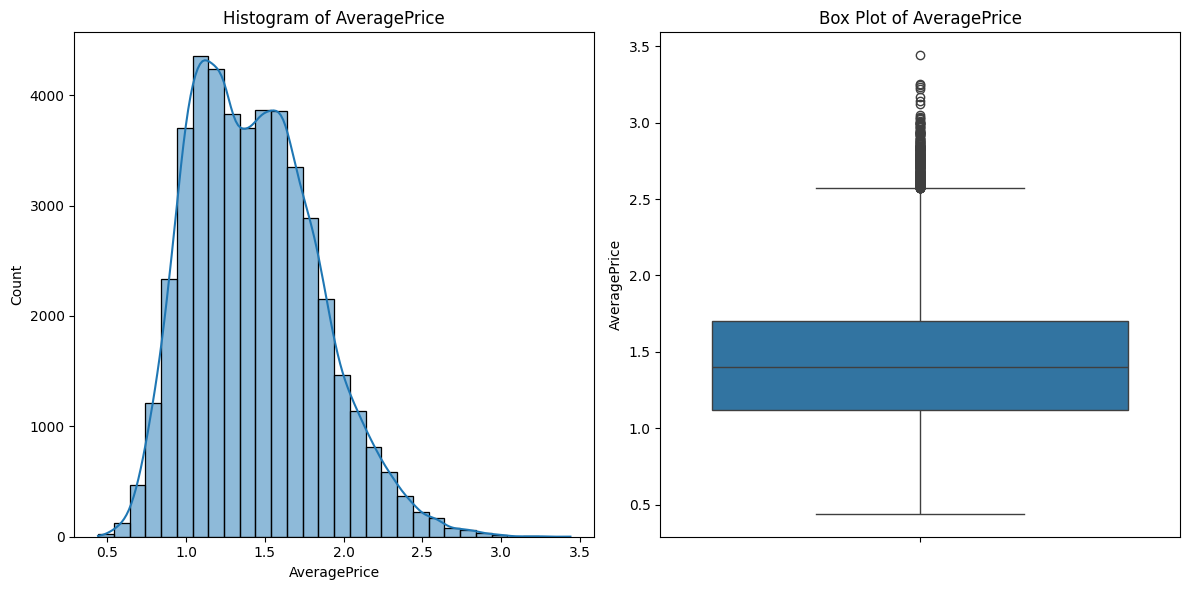


Analysis for TotalVolume:

count    4.502700e+04
mean     2.315604e+05
std      5.588753e+05
min      0.000000e+00
25%      4.843850e+03
50%      5.033755e+04
75%      2.444106e+05
max      1.121360e+07
Name: TotalVolume, dtype: float64


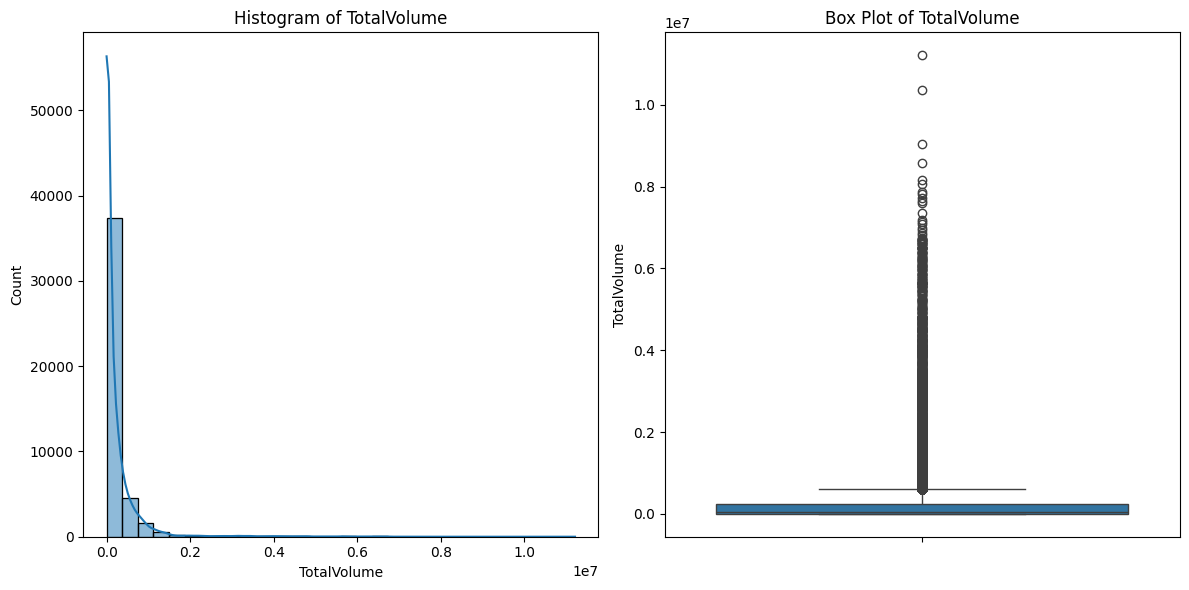


Analysis for plu4046:

count    4.502700e+04
mean     1.070827e+05
std      2.853490e+05
min      0.000000e+00
25%      4.590600e+02
50%      9.187370e+03
75%      1.025063e+05
max      4.794142e+06
Name: plu4046, dtype: float64


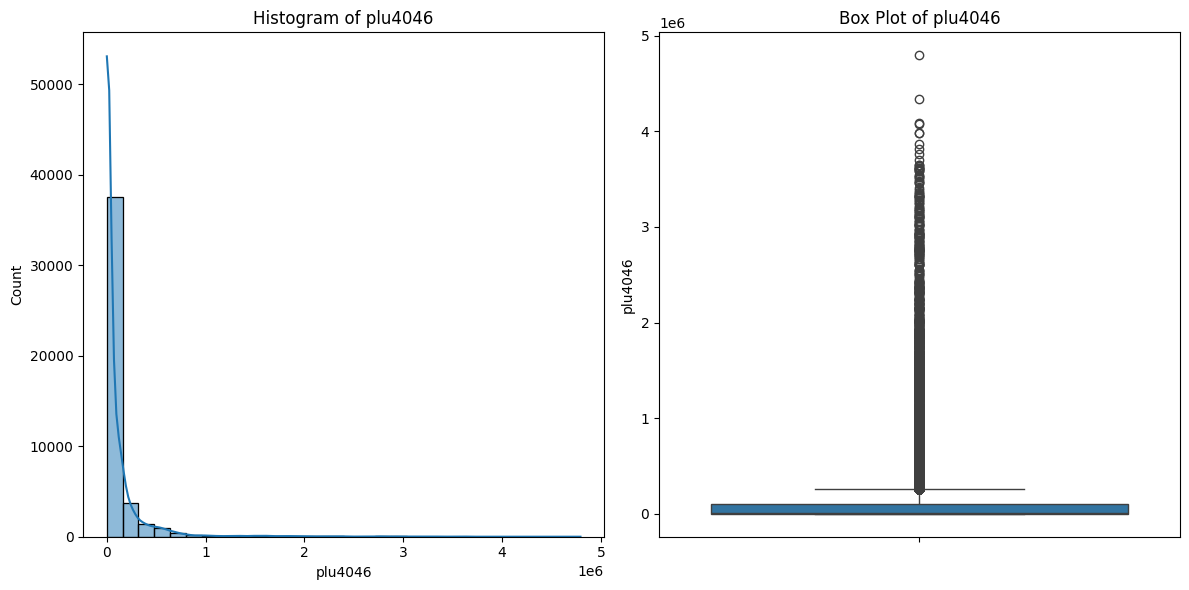


Analysis for plu4225:

count    4.502700e+04
mean     7.922380e+04
std      2.069269e+05
min      0.000000e+00
25%      1.560195e+03
50%      1.094023e+04
75%      6.402722e+04
max      3.950852e+06
Name: plu4225, dtype: float64


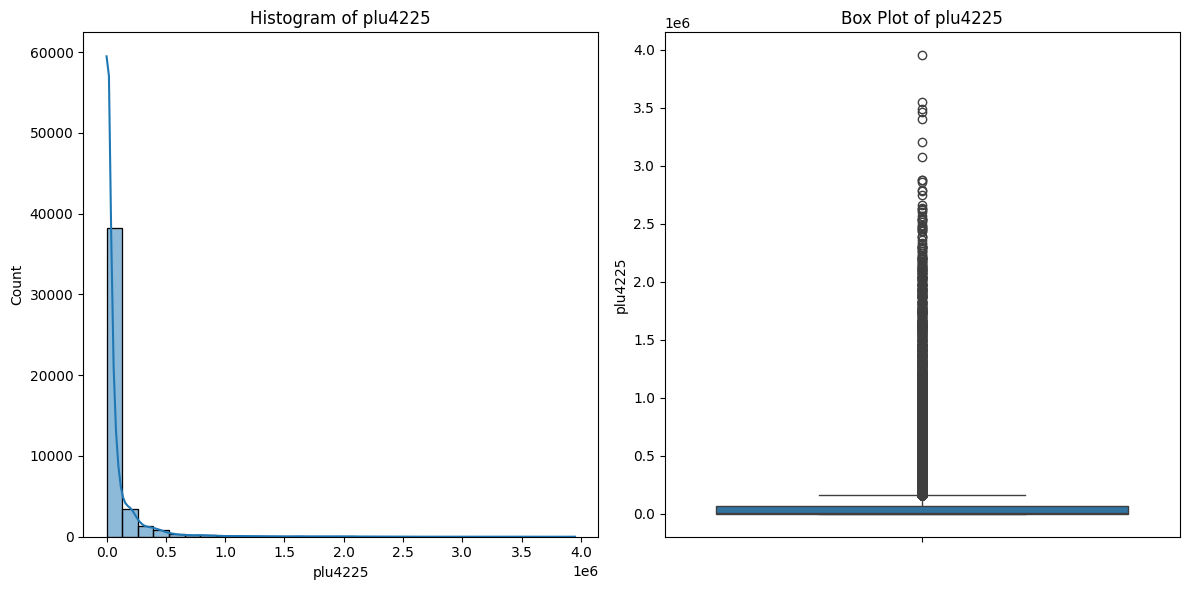


Analysis for plu4770:

count    4.502700e+04
mean     9.004546e+03
std      4.470108e+04
min      0.000000e+00
25%      0.000000e+00
50%      5.150000e+01
75%      2.271010e+03
max      1.419739e+06
Name: plu4770, dtype: float64


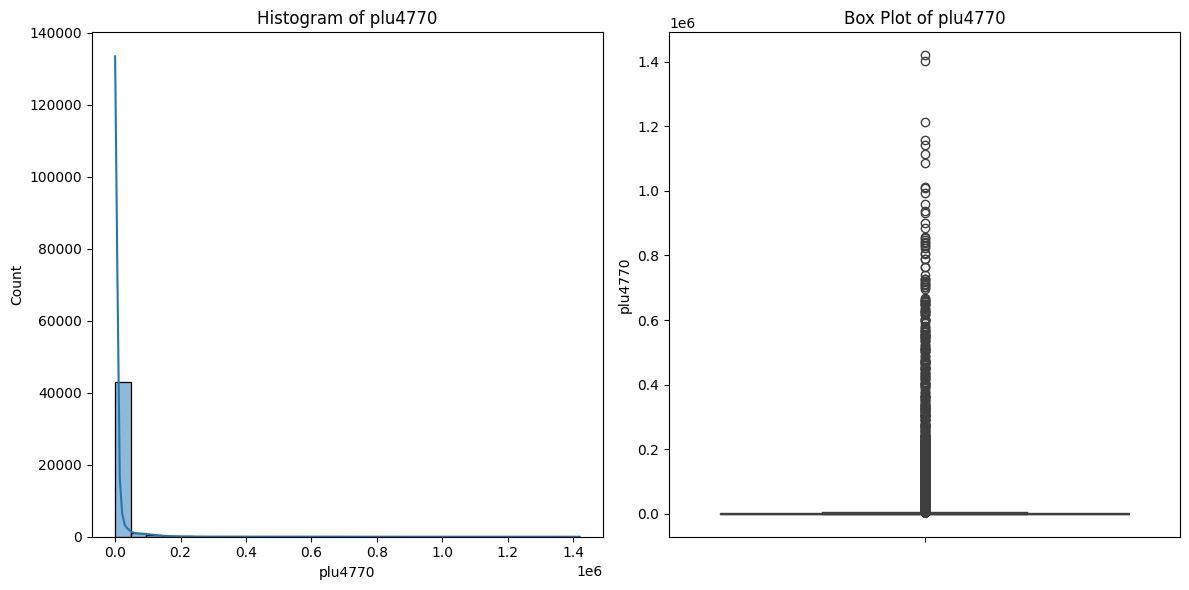


Analysis for TotalBags:

count    4.502700e+04
mean     3.624937e+04
std      1.365644e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.271980e+04
max      3.462626e+06
Name: TotalBags, dtype: float64


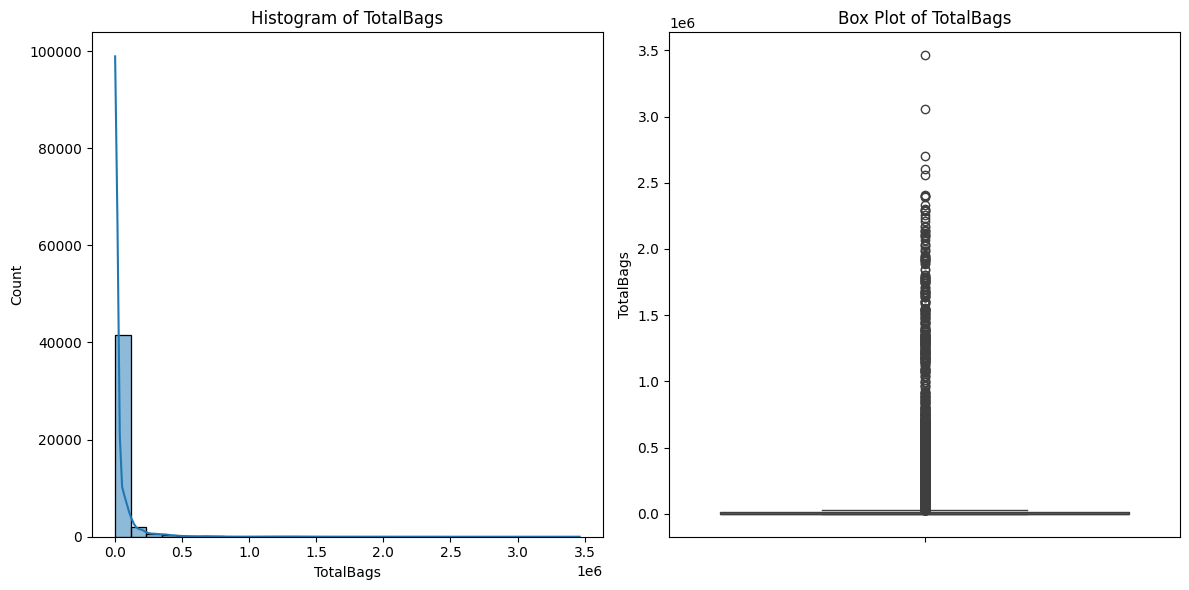


Analysis for SmallBags:

count    4.502700e+04
mean     3.002422e+04
std      1.232632e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.039000e+04
max      3.403581e+06
Name: SmallBags, dtype: float64


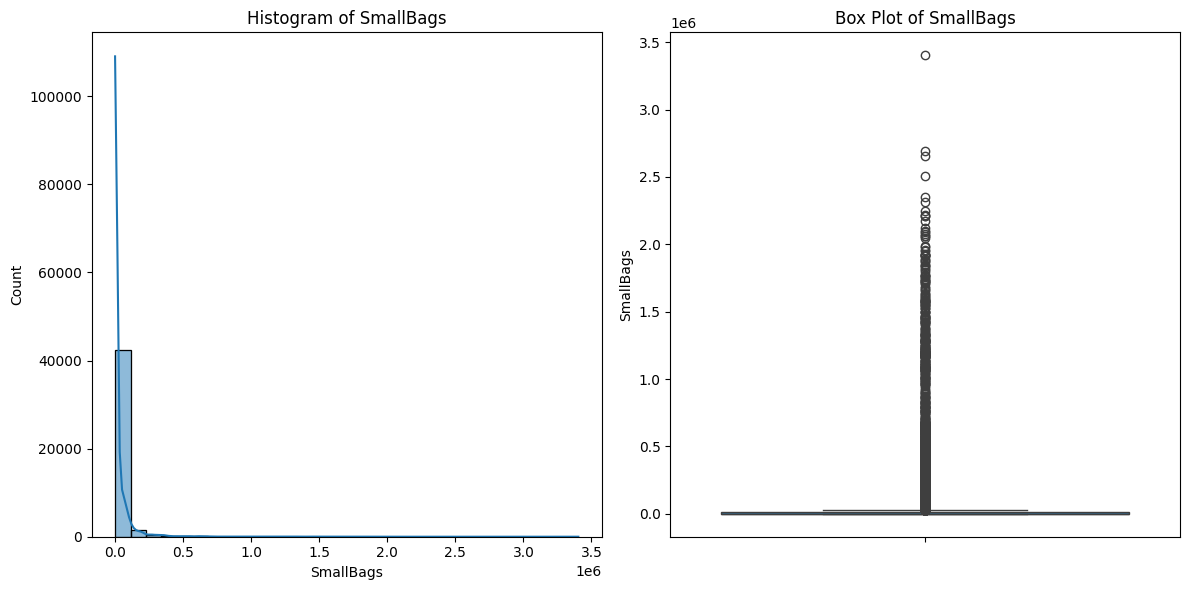


Analysis for LargeBags:

count     45027.000000
mean       5484.962130
std       24937.602889
min           0.000000
25%           0.000000
50%           0.000000
75%         464.535000
max      706052.840000
Name: LargeBags, dtype: float64


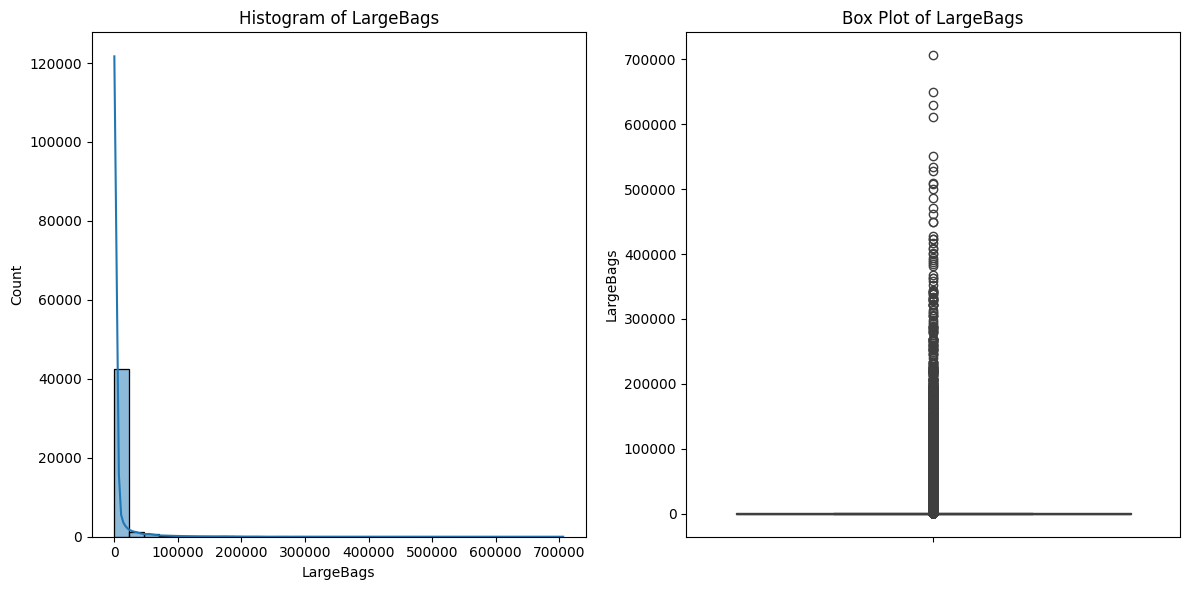


Analysis for XLargeBags:

count    45027.000000
mean       740.186495
std       4306.947542
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      81066.260000
Name: XLargeBags, dtype: float64


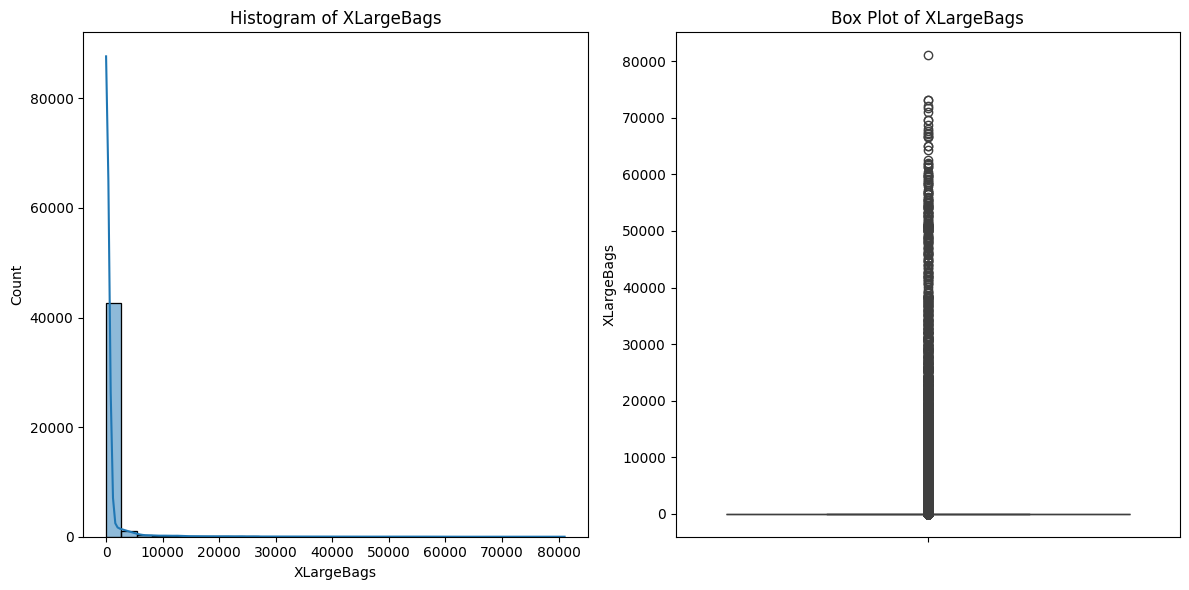

In [29]:
# Perform univariate analysis
univariate_analysis(city_level_data)

# Prepare the data
- Fix Skewness
- Remove Outliers
- Encoding Categorical Variables
- Remove Unnessesary
- Feature Scaling

## Fix Skewness

In [26]:
city_level_data_prep = city_level_data.copy()

In [27]:
import numpy as np

# Select numerical columns excluding 'AveragePrice'
numeric_cols = city_level_data_prep.select_dtypes(include=['number']).columns.drop('AveragePrice', errors='ignore')

# Check skewness
skewness = city_level_data_prep[numeric_cols].skew().sort_values(ascending=False)
print("Skewness before transformation:\n", skewness)

# Apply log transformation to highly skewed columns (absolute skew > 1)
skewed_features = skewness[abs(skewness) > 1].index

for col in skewed_features:
    city_level_data_prep[col] = np.log1p(city_level_data_prep[col])

print("Skewness fixed for:", list(skewed_features))

Skewness before transformation:
 plu4770        12.827736
SmallBags      10.157270
LargeBags       9.859239
TotalBags       9.382822
XLargeBags      9.356591
TotalVolume     6.655211
plu4046         6.429739
plu4225         6.369474
dtype: float64


Skewness fixed for: ['plu4770', 'SmallBags', 'LargeBags', 'TotalBags', 'XLargeBags', 'TotalVolume', 'plu4046', 'plu4225']


## Remove Outliers

In [57]:
# Select numerical columns excluding 'AveragePrice'
numeric_cols = city_level_data_prep.select_dtypes(include=['number']).columns.drop('AveragePrice', errors='ignore')

Q1 = city_level_data_prep[numeric_cols].quantile(0.25)
Q3 = city_level_data_prep[numeric_cols].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a mask for numerical columns only (excluding 'AveragePrice')
mask = (city_level_data_prep[numeric_cols] >= lower_bound) & (city_level_data_prep[numeric_cols] <= upper_bound)

# Keep all rows where non-target numeric columns are within bounds
city_level_data_prep = city_level_data_prep.loc[mask.all(axis=1)]

print("Outliers removed successfully (excluding 'AveragePrice')!")

Outliers removed successfully (excluding 'AveragePrice')!


## Check if the process worked


Analysis for AveragePrice:

count    45027.000000
mean         1.435606
std          0.401477
min          0.440000
25%          1.120000
50%          1.401090
75%          1.700000
max          3.440830
Name: AveragePrice, dtype: float64


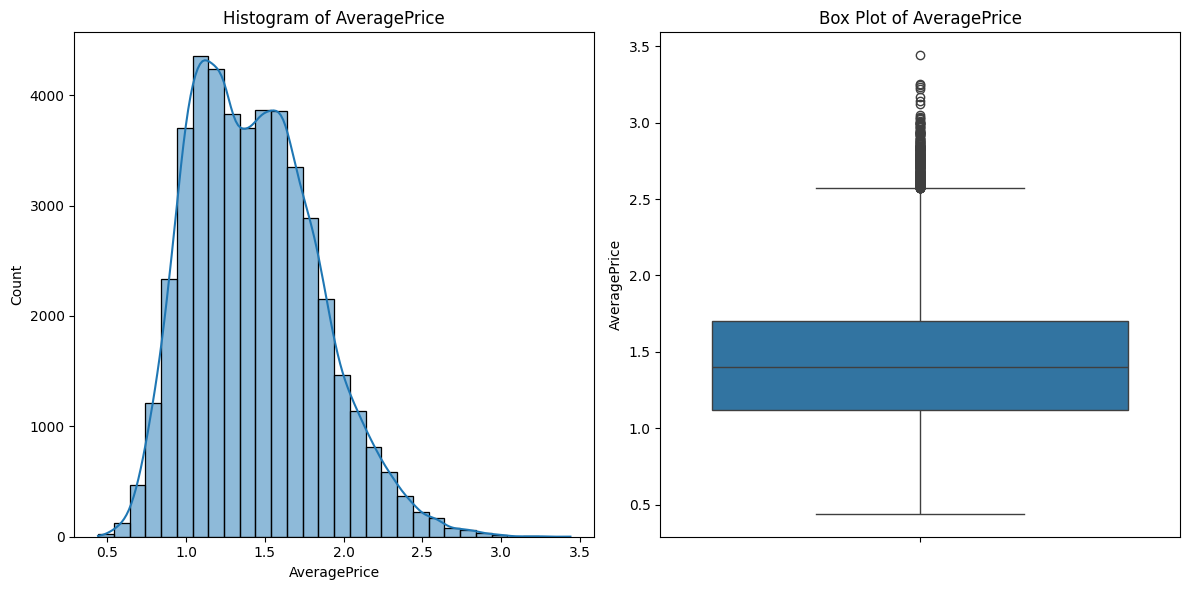


Analysis for TotalVolume:

count    45027.000000
mean        10.410647
std          2.420311
min          0.000000
25%          8.485672
50%         10.826526
75%         12.406609
max         16.232638
Name: TotalVolume, dtype: float64


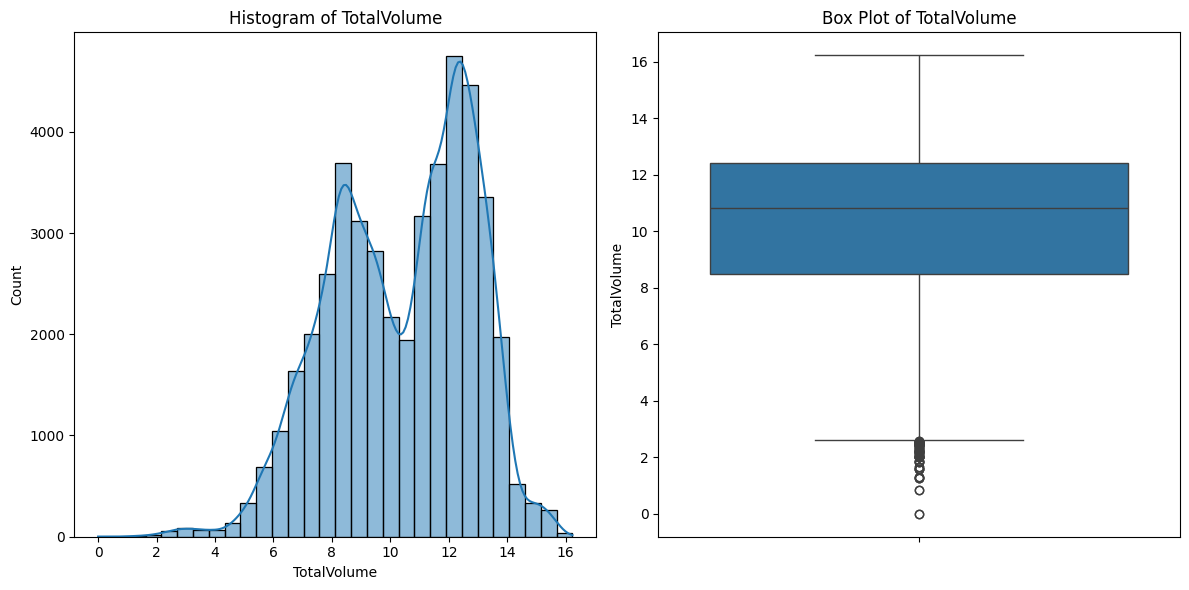


Analysis for plu4046:

count    45027.000000
mean         8.670779
std          3.314697
min          0.000000
25%          6.131357
50%          9.125694
75%         11.537689
max         15.382906
Name: plu4046, dtype: float64


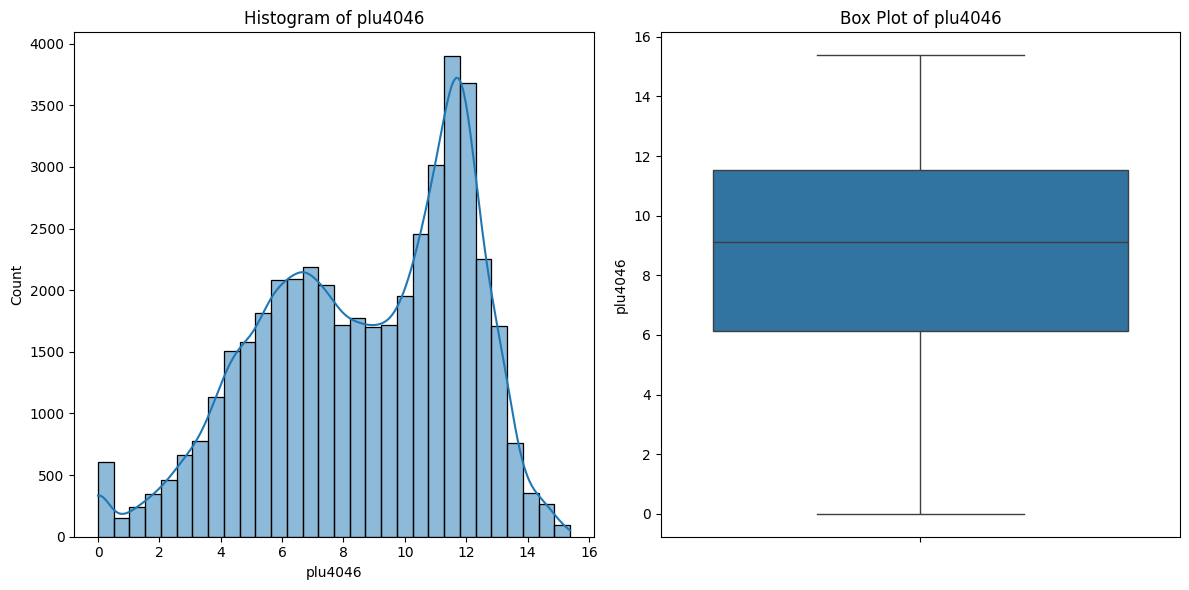


Analysis for plu4225:

count    45027.000000
mean         8.974903
std          2.835536
min          0.000000
25%          7.353207
50%          9.300294
75%         11.067079
max         15.189442
Name: plu4225, dtype: float64


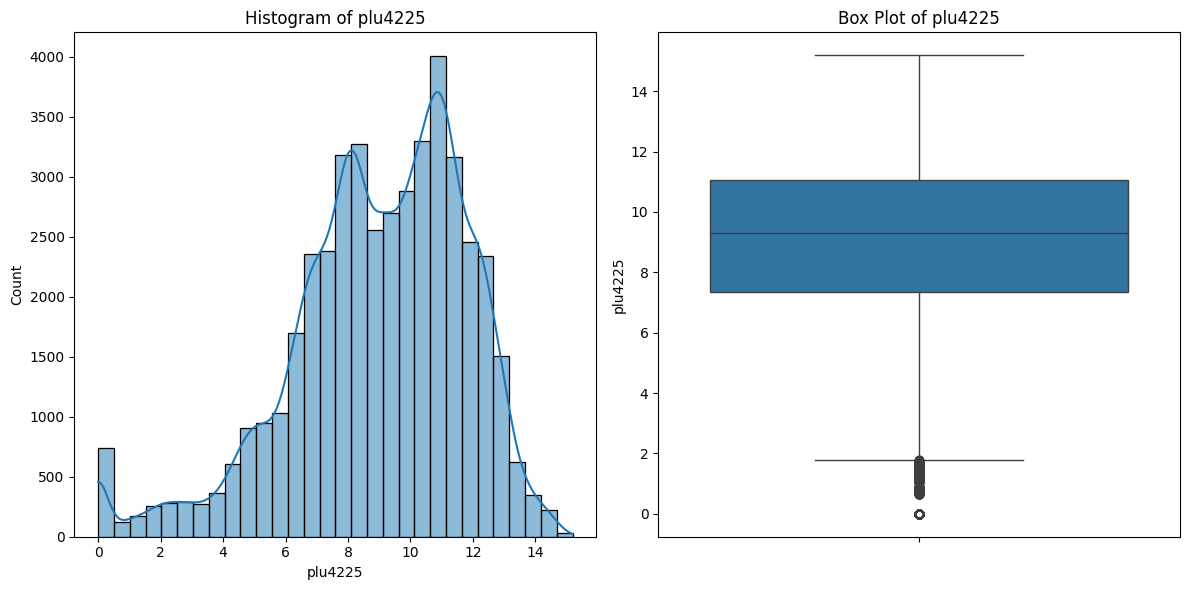


Analysis for plu4770:

count    45027.000000
mean         4.166346
std          3.927171
min          0.000000
25%          0.000000
50%          3.960813
75%          7.728420
max         14.165984
Name: plu4770, dtype: float64


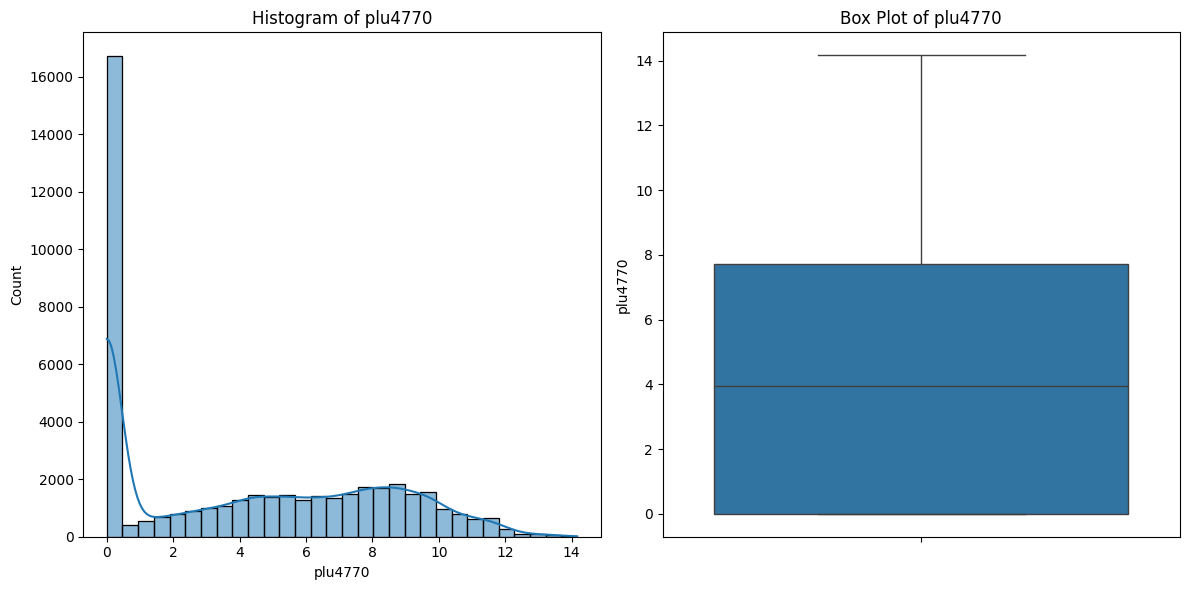


Analysis for TotalBags:

count    45027.000000
mean         4.148332
std          5.042749
min          0.000000
25%          0.000000
50%          0.000000
75%          9.450994
max         15.057538
Name: TotalBags, dtype: float64


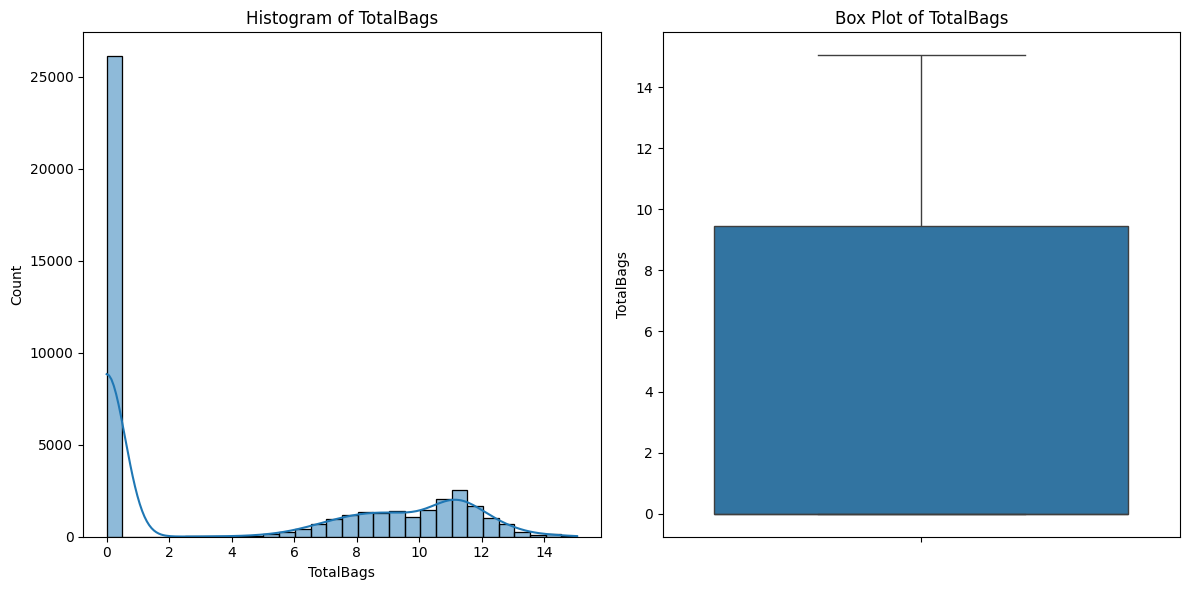


Analysis for SmallBags:

count    45027.000000
mean         3.971545
std          4.904139
min          0.000000
25%          0.000000
50%          0.000000
75%          9.248695
max         15.040339
Name: SmallBags, dtype: float64


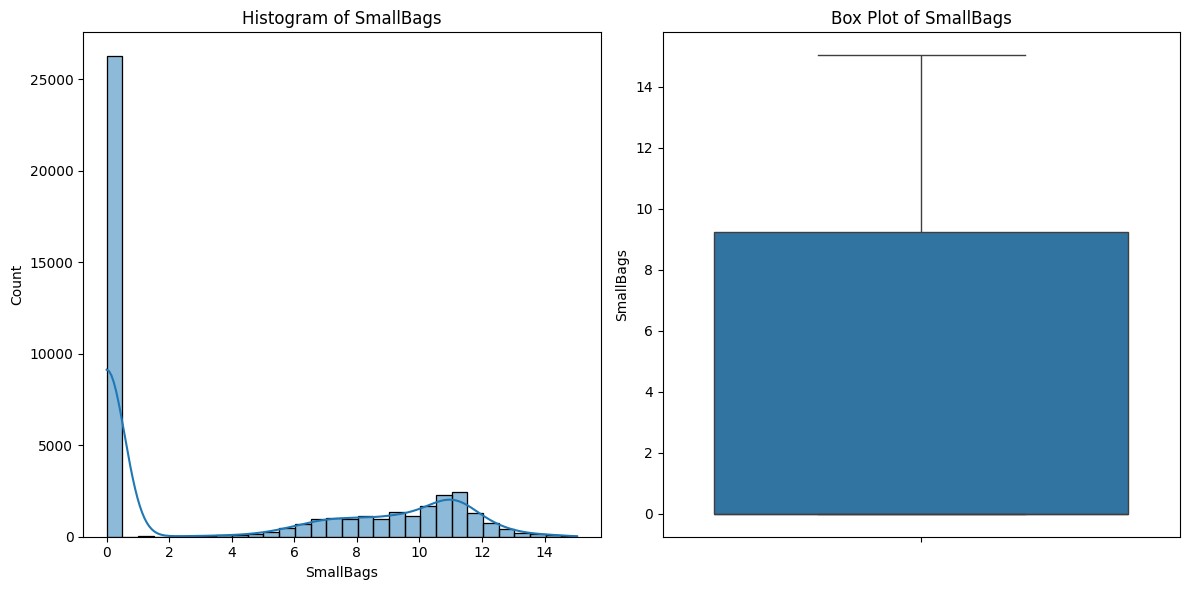


Analysis for LargeBags:

count    45027.000000
mean         2.561168
std          3.870675
min          0.000000
25%          0.000000
50%          0.000000
75%          6.143187
max         13.467447
Name: LargeBags, dtype: float64


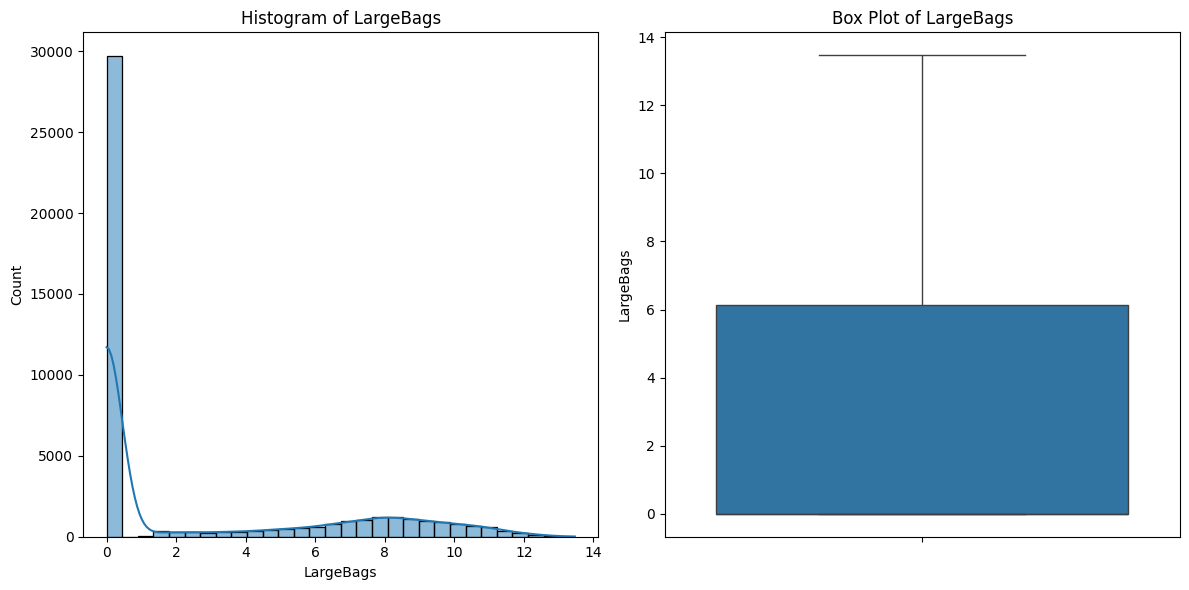


Analysis for XLargeBags:

count    45027.000000
mean         0.946705
std          2.501764
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.303034
Name: XLargeBags, dtype: float64


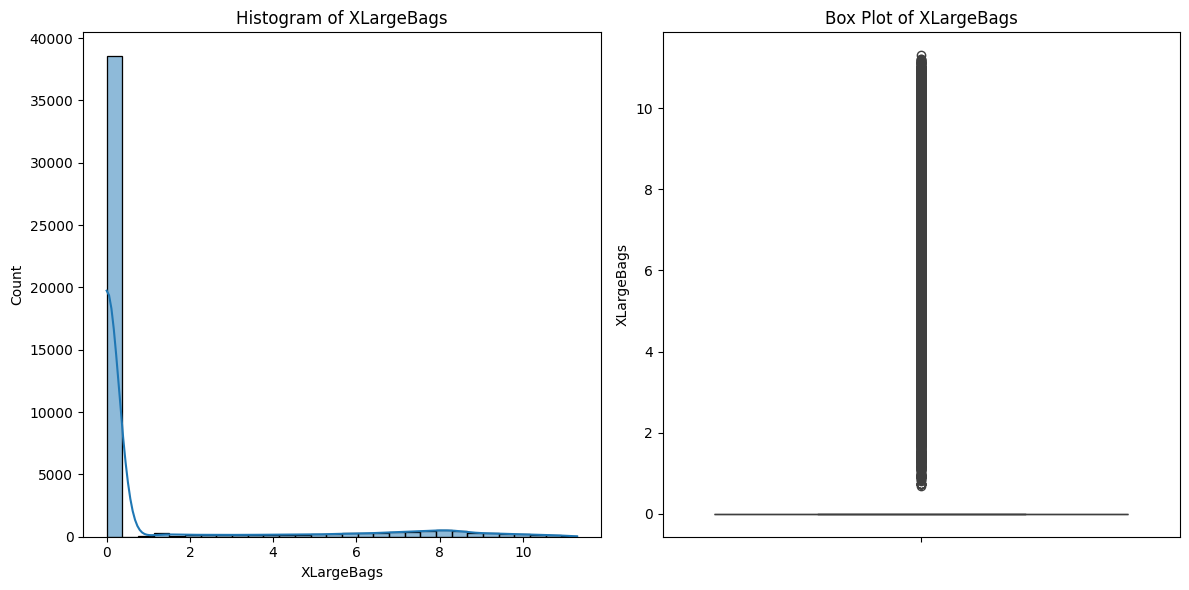

In [13]:
# Perform univariate analysis
univariate_analysis(city_level_data_prep)

## Encoding Categorical Variables

In [14]:
# Apply One-Hot Encoding
city_level_data_prep = pd.get_dummies(city_level_data_prep, columns=['region', 'type'], drop_first=True).astype(int)

print("Categorical variables encoded!")

Categorical variables encoded!


In [28]:
city_level_data_prep.shape

(45027, 12)

In [29]:
city_level_data_prep.head()

,Date,AveragePrice,TotalVolume,plu4046,plu4225,plu4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region
0,2015-01-04,1.22,10.618256,7.944669,10.250208,3.929863,9.181680,9.125646,6.273877,0.0,conventional,Albany
1,2015-01-04,1.79,7.226173,4.067658,5.042651,0.000000,7.059317,7.059317,0.000000,0.0,organic,Albany
2,2015-01-04,1.00,12.983153,12.805742,10.078372,4.420646,10.753997,9.723652,10.312601,0.0,conventional,Atlanta
3,2015-01-04,1.76,8.255228,7.313987,6.845188,0.000000,7.250770,6.977608,5.822572,0.0,organic,Atlanta
4,2015-01-04,1.08,13.577286,10.896523,13.222945,10.596535,11.857491,11.828809,8.291950,0.0,conventional,BaltimoreWashington


## Drop Unnecessary Columns

In [30]:
city_level_data_prep.drop(columns=['Date', 'type', 'region'], inplace=True)

## Feature Scaling

In [31]:
# Identify numeric columns excluding 'AveragePrice'
numeric_cols = city_level_data_prep.select_dtypes(include=['number']).columns.drop('AveragePrice', errors='ignore')

# Initialize the scaler
scaler = StandardScaler()

# Scale only the selected numeric features
scaled_features = scaler.fit_transform(city_level_data_prep[numeric_cols])

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=numeric_cols, index=city_level_data_prep.index)

# Reattach the unscaled 'AveragePrice' and any other non-numeric columns
city_level_data_prep[numeric_cols] = scaled_df  # Replace only scaled columns, keep others intact

print("Data scaling completed (excluding 'AveragePrice').")

Data scaling completed (excluding 'AveragePrice').


In [32]:
city_level_data_prep

,AveragePrice,TotalVolume,plu4046,plu4225,plu4770,TotalBags,SmallBags,LargeBags,XLargeBags
0,1.220000,0.085779,-0.219060,0.449763,-0.060218,0.998147,1.050981,0.959199,-0.378419
1,1.790000,-1.315744,-1.388716,-1.386791,-1.060915,0.577268,0.629633,-0.661693,-0.378419
2,1.000000,1.062894,1.247478,0.389161,0.064755,1.309948,1.172922,2.002627,-0.378419
3,1.760000,-0.890564,-0.409331,-0.751089,-1.060915,0.615234,0.612971,0.842602,-0.378419
4,1.080000,1.308375,0.671485,1.498161,1.637377,1.528778,1.602188,1.480580,-0.378419
...,...,...,...,...,...,...,...,...,...
53408,1.616528,-1.880547,-1.092880,-1.304308,-1.060915,-0.822642,-0.809844,-0.661693,-0.378419
53409,1.421139,-1.924532,-0.983652,-1.569145,-1.060915,-0.822642,-0.809844,-0.661693,-0.378419
53410,1.550513,-1.303329,-1.009048,-0.661141,-1.060915,-0.822642,-0.809844,-0.661693,-0.378419
53412,1.618931,-0.291671,0.288772,-0.661104,-1.060915,-0.822642,-0.809844,-0.661693,-0.378419


# Train-Test Split

In [33]:
# Define target variable (y) and predictors (X)
X = city_level_data_prep.drop(columns=['AveragePrice'])
y = city_level_data_prep['AveragePrice']

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split successfully!")

Data split successfully!


# Train and Evaluate Models
We will use:

- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor
- Gradient Boosting Regressor
- MLP Regressor (Neural Network)

We evaluate using Mean Squared Error (MSE), Mean Absolute Error (MAE), and R²

In [ ]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Train & Evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict on test set
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Compute confidence interval for predictions
    residuals = y_test - y_pred
    std_dev = np.std(residuals)
    confidence_interval = 1.96 * std_dev / np.sqrt(len(y_test))  # 95% Confidence Interval

    # Store results
    results[name] = {
        "MSE": mse, 
        "MAE": mae, 
        "R²": r2, 
        "Confidence Interval (±)": confidence_interval
    }
    
    print(f"{name}: MSE={mse:.4f}, MAE={mae:.4f}, R²={r2:.4f}, Confidence Interval (±){confidence_interval:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

Linear Regression: MSE=0.0952, MAE=0.2425, R²=0.3996, Confidence Interval (±)0.0064
Decision Tree: MSE=0.1009, MAE=0.2216, R²=0.3641, Confidence Interval (±)0.0066
Random Forest: MSE=0.0527, MAE=0.1653, R²=0.6679, Confidence Interval (±)0.0047


## Predicted vs Actual Plot for Each Model

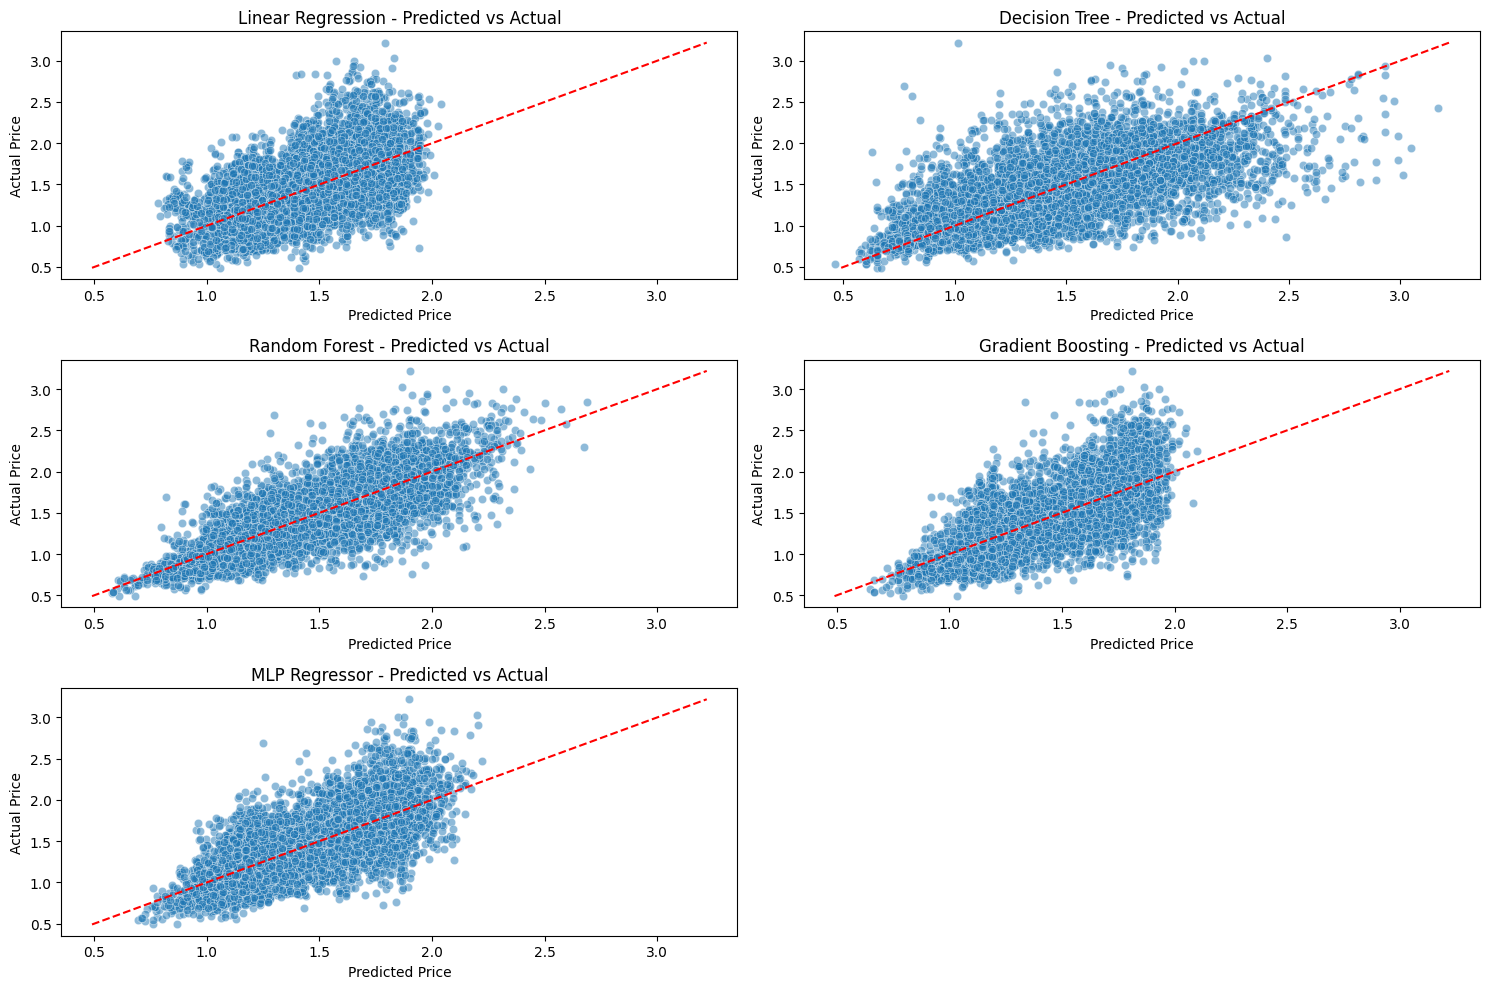

In [35]:
# Plot predicted vs. actual for each model
plt.figure(figsize=(15, 10))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)  # Get predictions

    plt.subplot(3, 2, i)  # Create subplot
    sns.scatterplot(x= y_pred, y= y_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Perfect prediction line
    plt.xlabel("Predicted Price")
    plt.ylabel("Actual Price")
    plt.title(f"{name} - Predicted vs Actual")

plt.tight_layout()
plt.show()